In [ ]:
# Econometric modeling combining MCMC algorithm and random coefficient quantile AR model 
# https://www.researchgate.net/figure/The-MCMC-AR-econometric-model_fig3_389540416

import requests
import pandas as pd
import matplotlib.pyplot as plt

# Fetch data
url = "http://127.0.0.1:8000/api/v1/data/?table_name=precios_materiales&limit=1000"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
    print(f"✓ Successfully fetched {len(data['data'])} records")
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}") 
    raise
# Convert to Data Frame
df = pd.DataFrame(data['data'])

#Convert date to date of Dataframe
df['date'] = pd.to_datetime(df['date'])


#Variable a analizar 
var_analizar = 'scrap_mxn'

/Users/alangarcia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


✓ Successfully fetched 190 records


En este código generaremos datos sintéticos para un modelo ARIMA(p,d,q)

Recordemos que
* p : corresponde al modelo autoregresivo
* d : corresponde a la diferencia
* q : corresponde al modelo de medias móviles

La expresión para el modelo ARIMA es la siguiente:

Por un lado tenemos el modelo ARMA(p,q):
$$X_t = c + \phi_1X_{t-1} + \phi_2X_{t-2} + ... + \phi_pX_{t-p} + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_q\epsilon_{t-q}$$
El cual debe ser diferenciado d veces.

El termino c es:
    Constante/intercepto del modelo ARMA, despues de diferenciar
    Cuando uso ARIMA (p,d, q) con d >0 hay dos opciones
      1) Modelo intercpet (drift)

      2) ARIMA constante 

Si c = 5, significa que esta muestrando valor fijo , permite que el ARIMA capture tendencia promedio despues de diferenciar, 
Hace los residuos mas estacionarios
Da mejor fit general


           


## Paso 1: Visualizar Datos

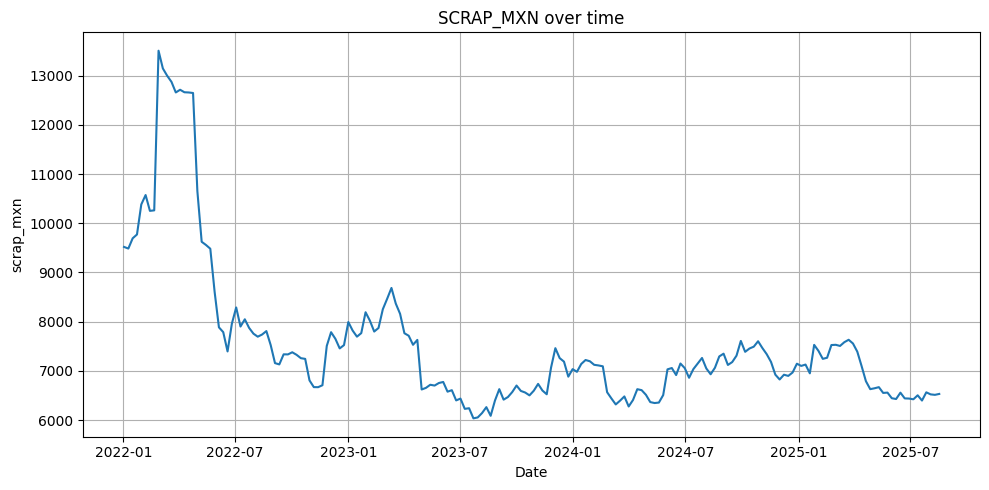

In [3]:
serie = df[var_analizar]

# Plot with date on x-axis
plt.figure(figsize=(10, 5))
plt.plot(df['date'], serie, linestyle='-')
plt.title(f"{var_analizar.upper()} over time")
plt.xlabel("Date")
plt.ylabel(var_analizar)
plt.grid(True)
plt.tight_layout()
plt.show()

## Visualizacion de grafica de autocorrelacion y autocorrelacion parcial

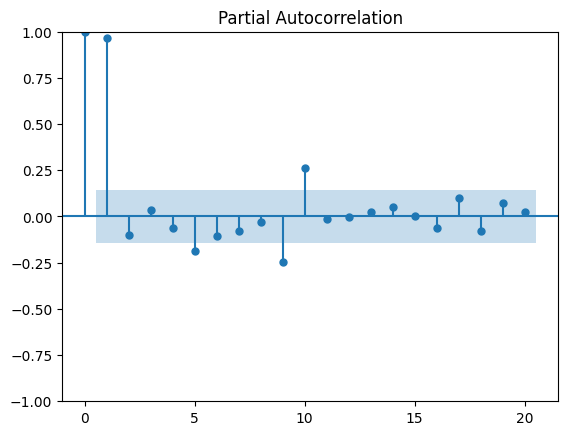

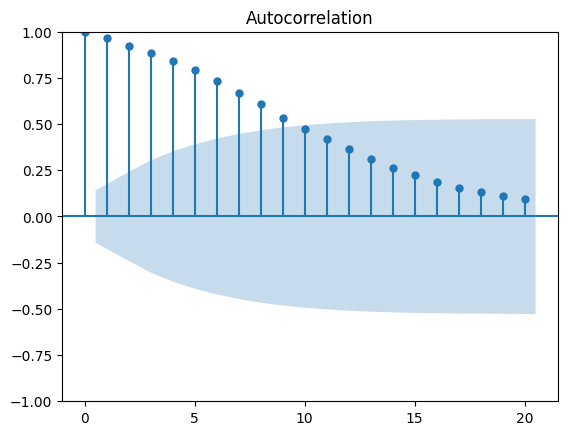

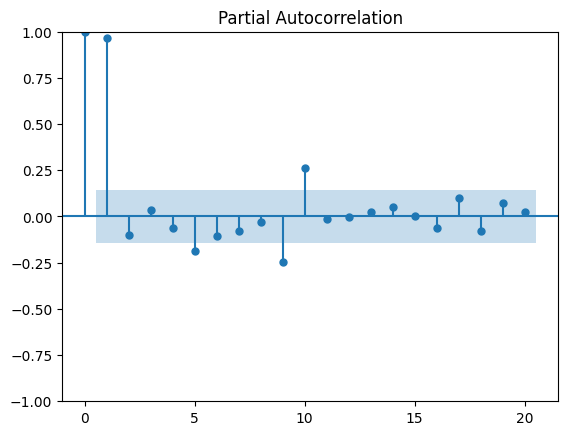

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(serie, lags=20)
plot_pacf(serie, lags=20)

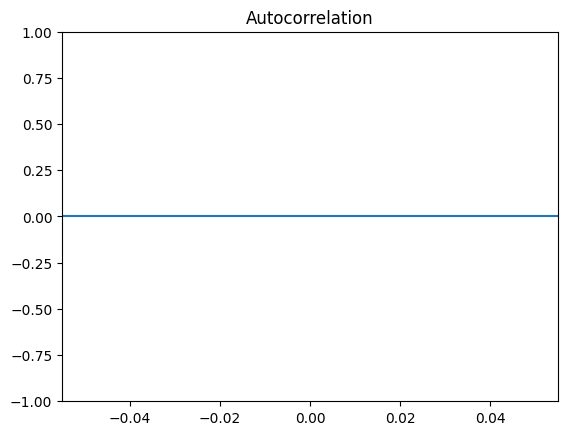

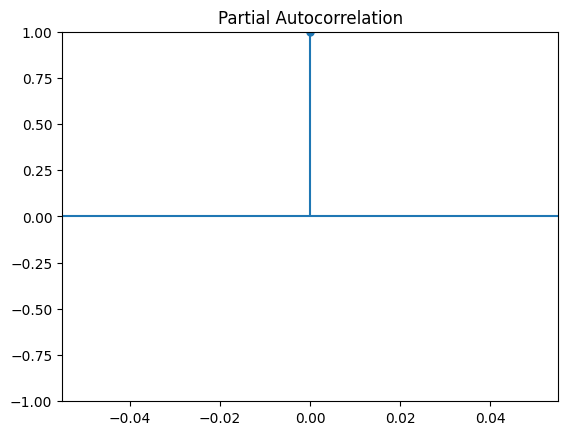

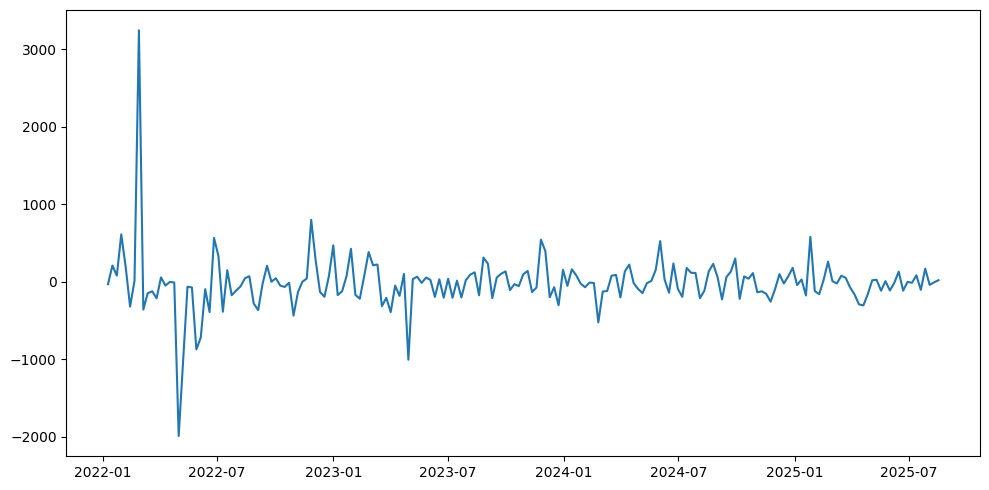

In [ ]:
serie_diff = serie.diff()

plot_acf(serie_diff)
plot_pacf(serie_diff)

plt.figure(figsize=(10,5))
plt.plot(df['date'], serie_diff)
plt.tight_layout()
plt.show()

Funcion Model clase:

def model(x, **kwargs) :

  p = kwargs['p']
  q = kwargs['q']
  c = kwargs['c']
  T = kwargs['T']
  epsilon = kwargs['epsilon']

  phi = x[:p]
  theta = x[-q:]

  epsilon = np.random.randn(T)

  X = create_data(c, p, q, phi, theta, epsilon, T)

  return X


Esta funcion existe para que dado un parametro devuelva, la probabilidad, log-verosimilitud, log-posterior

def model(params, y):
    return log_likehood_of_ARIMA(params, y)

La funcion 

## Implementacion de MCMC

In [28]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def log_likelihood_arima(params, y, p, d, q, include_const=True):
    """
    Calcula la log-verosimilitud del modelo ARIMA(p,d,q)
    usando statsmodels internamente para evaluar la LL.

    params = [c?, phi1..phip, theta1..thetaq, sigma2]
    """

    idx = 0 
    #Constante
    if include_const:
        c = params[idx]
        idx +=1
    else:
        c = 0

    #AR
    phi = params[idx : idx + p]
    idx += p

    #MA
    theta = params[idx : idx + q]

    #Varianza
    sigma2 = params[idx]

    #valores que statsmodels ARIMA espera
    order = (p, d, q)

    try:
        model = ARIMA(y, order=order, trend='c' if include_const else 'n')
        fitted = model.filter([c] + list[phi] + list[theta] + sigma2)
        ll = fitted.llf
    except:
        return -np.inf #modelo invalido

    return ll




In [25]:
def metropolis_hastings(y, p=2, d=1, q=3, n_iter=5000, step_size=0.05, include_const=True):
    """
    MCMC Metropolis-Hastings para ARIMA(p,d,q)
    """

    #numero de parametros
    k = p + q + 1 # sigma2
    if include_const:
        k += 1

    #Inizializacion
    params = np.random.normal(0,1,k)
    params[-1] = abs(params[-1]) + 1e-3 #Sigma >0

    samples = np.zeros((n_iter, k))

    #Log likehood inicial
    ll_current = log_likelihood_arima(params, y, p, d, q, include_const)

    for i in range(n_iter):
        proposal = params + np.random.normal(0, step_size, k)
        proposal[-1] = abs(proposal[-1]) + 1e-3  # sigma2 > 0

        ll_proposal = log_likelihood_arima(proposal, y, p, d, q, include_const)

        # Criterio Metropolis
        accept_ratio = np.exp(ll_proposal - ll_current)

        if np.random.rand() < accept_ratio:
            params = proposal
            ll_current = ll_proposal

        samples[i] = params

        if i % 500 == 0:
            print(f"Iter {i}: LL={ll_current:.2f}")

    return samples 





In [31]:
#Best AIC Order: (2, 1, 3) with AIC: 2241.8620220353173
samples = metropolis_hastings(serie, p=2, d=1, q=3, n_iter=3000, step_size=0.02, include_const=True)



Iter 0: LL=-inf
Iter 500: LL=-inf
Iter 1000: LL=-inf
Iter 1500: LL=-inf
Iter 2000: LL=-inf
Iter 2500: LL=-inf


In [22]:
import numpy as np
class MH :

  def __init__(self, model, data, **kwargs) :
    self.samples = []
    self.U = []
    self.data = data
    self.model = model
    self.kwargs = kwargs

  def sample(self, x0, max_it) :

    self.samples.append(x0)
    e0 = self.energy(x0)

    self.U.append(e0)

    for t in range(1,max_it) :

      x_current = self.samples[-1]
      x_guess = self.guess(x_current)

      e_guess = self.energy(x_guess)
      #metropolis-hastings criterion
      rho = self.U[-1] - e_guess

      u = np.random.uniform()

      if np.log(u) <rho :
        #accept proposal
        self.samples.append(x_guess)
        self.U.append(e_guess)

      else :

        self.samples.append(x_current)
        self.U.append(self.U[-1])

      if t % 500 == 0 :
        print(t, self.samples[-1], self.U[-1])

    return 0


  def support(self, x) :

    if (x < -100).any() or (x > 100).any() :
      return False
    return True

  def guess(self, x) :

    w = [0.7,0.3]

    while True :
      q_i = np.random.choice([self.random_walk_proposal, self.reverse_proposal],p=w)
      x_ = q_i(x)

      if self.support(x_) :
        break

    return x_

  def energy(self, x) :

    data = self.data

    y = self.model(x, **self.kwargs)

    return np.linalg.norm(y - data)**2

  def random_walk_proposal(self, x) :

    u = np.random.uniform()
    factor = 0.25

    if u < 0.5 :

      i = np.random.randint(0,len(x))

      y = x.copy()
      y[i] = y[i] + factor*np.random.randn(1)

    else :

      y = x.copy()
      y += factor*np.random.randn(len(x))

    return y

  def reverse_proposal(self, x) :

    i = np.random.randint(0,len(x))

    y = x.copy()
    y[i] = -y[i]

    return y

In [ ]:
mh_sampler = MH(serie, serie)